In [1]:
import pickle, gzip, numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import time
import random


from sklearn.svm import LinearSVC
import scipy.sparse as sparse
from sklearn.decomposition import PCA
from sklearn import svm

## Read MNIST Data
### MNIST Database (mnist.pkl.gz) [Open Resource](https://academictorrents.com/details/323a0048d87ca79b68f12a6350a57776b6a3b7fb)

In [2]:
### Read data

def read_pickle_data(file_name):
    f = gzip.open(file_name, 'rb')
    data = pickle.load(f, encoding='latin1')
    f.close()
    return data

def get_MNIST_data():
    """
    Reads mnist dataset from file

    Returns:
        train_x - 2D Numpy array (n, d) where each row is an image
        train_y - 1D Numpy array (n, ) where each row is a label
        test_x  - 2D Numpy array (n, d) where each row is an image
        test_y  - 1D Numpy array (n, ) where each row is a label

    """
    train_set, valid_set, test_set = read_pickle_data('mnist.pkl.gz')
    train_x, train_y = train_set
    valid_x, valid_y = valid_set
    train_x = np.vstack((train_x, valid_x))
    train_y = np.append(train_y, valid_y)
    test_x, test_y = test_set
    return (train_x, train_y, test_x, test_y)

In [3]:
train_x, train_y, test_x, test_y = get_MNIST_data()

In [4]:
print(train_x.shape)
print(test_x.shape)

(60000, 784)
(10000, 784)


### Plot images

In [5]:
def plot_images(X):
    """
    X -  (n, 28*28) NumPy array (n datapoints each with d features)
    """
    if X.ndim == 1:
        X = np.array([X])
    num_images = X.shape[0]
    num_rows = math.floor(math.sqrt(num_images))
    num_cols = math.ceil(num_images/num_rows)
    for i in range(num_images):
        reshaped_image = X[i,:].reshape(28,28)
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(reshaped_image, cmap = cm.Greys_r)
        plt.axis('off')
    plt.show()

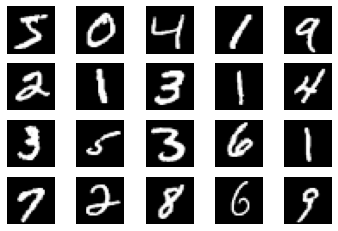

[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]


In [6]:
plot_images(train_x[0:20, :])
print(train_y[0:20])

### A function to calculate error rate for multi-class classification (Top-1 accuracy)

In [7]:
def multi_class_error_rate(actual,predicted):
    """
    actual    - (n, ) NumPy array containing the actual labels (int)
    predicted - (n, ) NumPy array containing the predicted labels (int) 
    """
    return 1-np.mean(actual == predicted)

## Model 1 - [Linear SVM (Support Vector Machine)](https://en.wikipedia.org/wiki/Support_vector_machine#Linear_SVM)
### - Package: [sklearn.svm.LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html)
### - The multi-class strategy: [one-vs-rest classifiers (by default)](https://en.wikipedia.org/wiki/Support_vector_machine#Multiclass_SVM)

In [8]:
def linear_svm_model(train_x,train_y,test_x,C):
    """
    Trains a linear SVM for multiclass classifciation using a one-vs-rest strategy
    Args:
        train_x - (n, d) NumPy array (n datapoints each with d features)
        train_y - (n, ) NumPy array containing the labels (int) for each training data point
        test_x  - (m, d) NumPy array (m datapoints each with d features)
        C       - Regularization parameter.The strength of the regularization is inversely proportional to C. 
                  Must be strictly positive.
    Returns:
        pred_test_y - (m,) NumPy array containing the labels (int) for each test data point
    """
    clf = LinearSVC(C = C, random_state = 0,max_iter=10000)
    clf.fit(train_x, train_y)
    pred_test_y = clf.predict(test_x)
    
    return pred_test_y 

In [9]:
start_time = time.time()
pred_test_y_LinearSVC = linear_svm_model(train_x,train_y,test_x,0.1)
end_time = time.time()
execution_time = end_time - start_time
print(f"execution time：{execution_time} seconds")

execution time：32.50487923622131 seconds


In [10]:
print('LinearSVC',multi_class_error_rate(test_y,pred_test_y_LinearSVC))

LinearSVC 0.08189999999999997


## Model 2 - [Polynomial SVM (Support Vector Machine)](https://en.wikipedia.org/wiki/Polynomial_kernel)
### - Package: [sklearn.svm.SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)
### - Applying polynomial svm to the original 784-dimensional in the original data would result in massive dimensionality. To avoid overfitting, apply the polynomial svm to the 10-dimensional PCA representation of the training data.

In [11]:
### create the top 10 principal components
pca_10        = PCA(n_components = 10)
train_x_pca10 = pca_10.fit_transform(train_x)
test_x_pca10  = pca_10.transform(test_x)

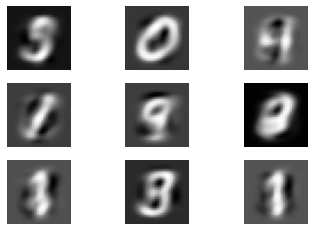

[5 0 4 1 9 2 1 3 1]


In [12]:
### Reconstructed images using the 10-dimensional principal component representation.
X_projected_pca10 = pca_10.inverse_transform(train_x_pca10)
plot_images(X_projected_pca10[0:9, :])
print(train_y[0:9])

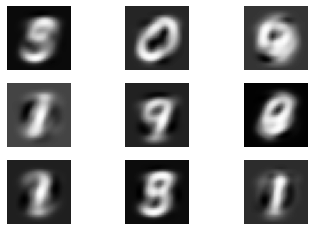

[5 0 4 1 9 2 1 3 1]


In [13]:
### Reconstructed images using the 5-dimensional principal component representation.
pca_5            = PCA(n_components = 5)
train_x_pca5     = pca_5.fit_transform(train_x)
test_x_pca5      = pca_5.transform(test_x)
X_projected_pca5 = pca_5.inverse_transform(train_x_pca5)
plot_images(X_projected_pca5[0:9, :])
print(train_y[0:9])

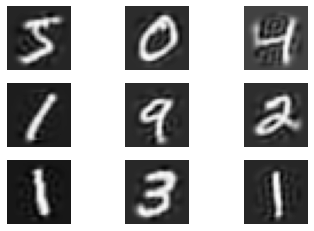

[5 0 4 1 9 2 1 3 1]


In [14]:
### Reconstructed images using the 100-dimensional principal component representation.
pca_100            = PCA(n_components = 100)
train_x_pca100     = pca_100.fit_transform(train_x)
test_x_pca100      = pca_100.transform(test_x)
X_projected_pca100 = pca_100.inverse_transform(train_x_pca100)
plot_images(X_projected_pca100[0:9, :])
print(train_y[0:9])

In [15]:
def poly_svm_model(train_x,train_y,test_x,degree):
    """
    Trains a linear SVM for multiclass classifciation using a one-vs-rest strategy
    Args:
        train_x - (n, d) NumPy array (n datapoints each with d features)
        train_y - (n, ) NumPy array containing the labels (int) for each training data point
        test_x  - (m, d) NumPy array (m datapoints each with d features)
    Returns:
        pred_test_y - (m,) NumPy array containing the labels (int) for each test data point
    """
    clf = svm.SVC(random_state = 0, kernel = 'poly', degree = degree)
    clf.fit(train_x, train_y)
    pred_test_y = clf.predict(test_x)    
    return pred_test_y 

In [16]:
start_time = time.time()
pred_test_y_polySVC_PCA10_d3 = poly_svm_model(train_x_pca10,train_y,test_x_pca10,3)
end_time = time.time()
execution_time = end_time - start_time
print(f"execution time：{execution_time} seconds")
print('polySVC_PCA10_d3',multi_class_error_rate(test_y,pred_test_y_polySVC_PCA10_d3))

execution time：37.54580593109131 seconds
polySVC_PCA10_d3 0.07330000000000003


In [17]:
start_time = time.time()
pred_test_y_polySVC_PCA10_d2 = poly_svm_model(train_x_pca10,train_y,test_x_pca10,2)
end_time = time.time()
execution_time = end_time - start_time
print(f"execution time：{execution_time} seconds")
print('polySVC_PCA10_d2',multi_class_error_rate(test_y,pred_test_y_polySVC_PCA10_d2))

execution time：53.3489670753479 seconds
polySVC_PCA10_d2 0.12729999999999997


## Model 3 - [Radial basis function SVM (Support Vector Machine)](https://en.wikipedia.org/wiki/Radial_basis_function_kernel)
### - Package: [sklearn.svm.SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)
### - Compare the results using the original data and the 10-dimensional PCA representation of the training data.

In [18]:
def rbf_svm_model(train_x,train_y,test_x):
    """
    Trains a linear SVM for multiclass classifciation using a one-vs-rest strategy
    Args:
        train_x - (n, d) NumPy array (n datapoints each with d features)
        train_y - (n, ) NumPy array containing the labels (int) for each training data point
        test_x  - (m, d) NumPy array (m datapoints each with d features)
    Returns:
        pred_test_y - (m,) NumPy array containing the labels (int) for each test data point
    """
    clf = svm.SVC(random_state = 0, kernel = 'rbf')
    clf.fit(train_x, train_y)
    pred_test_y = clf.predict(test_x)
    
    return pred_test_y 

In [19]:
start_time = time.time()
pred_test_y_rbfSVC_PCA10 = rbf_svm_model(train_x_pca10,train_y,test_x_pca10)
end_time = time.time()
execution_time = end_time - start_time
print(f"execution time：{execution_time} seconds")
print('rbfSVC_PCA10',multi_class_error_rate(test_y,pred_test_y_rbfSVC_PCA10))

execution time：43.18137288093567 seconds
rbfSVC_PCA10 0.06359999999999999


In [20]:
start_time = time.time()
pred_test_y_rbfSVC_ori = rbf_svm_model(train_x,train_y,test_x)
end_time = time.time()
execution_time = end_time - start_time
print(f"execution time：{execution_time} seconds")
print('rbfSVC_original data',multi_class_error_rate(test_y,pred_test_y_rbfSVC_ori))

execution time：332.2473590373993 seconds
rbfSVC_original data 0.02080000000000004


## Model 4 - [Multinomial (Softmax) Regression](https://en.wikipedia.org/wiki/Multinomial_logistic_regression)

### (1) [Softmax function](https://en.wikipedia.org/wiki/Softmax_function![image.png](attachment:image.png))
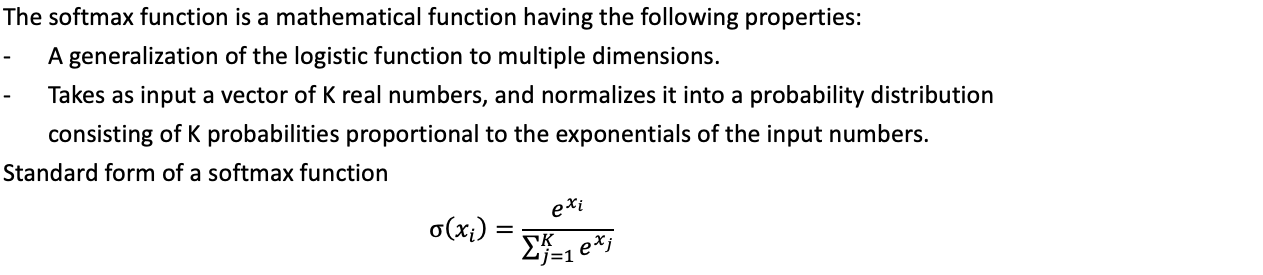

### (2) Temperature
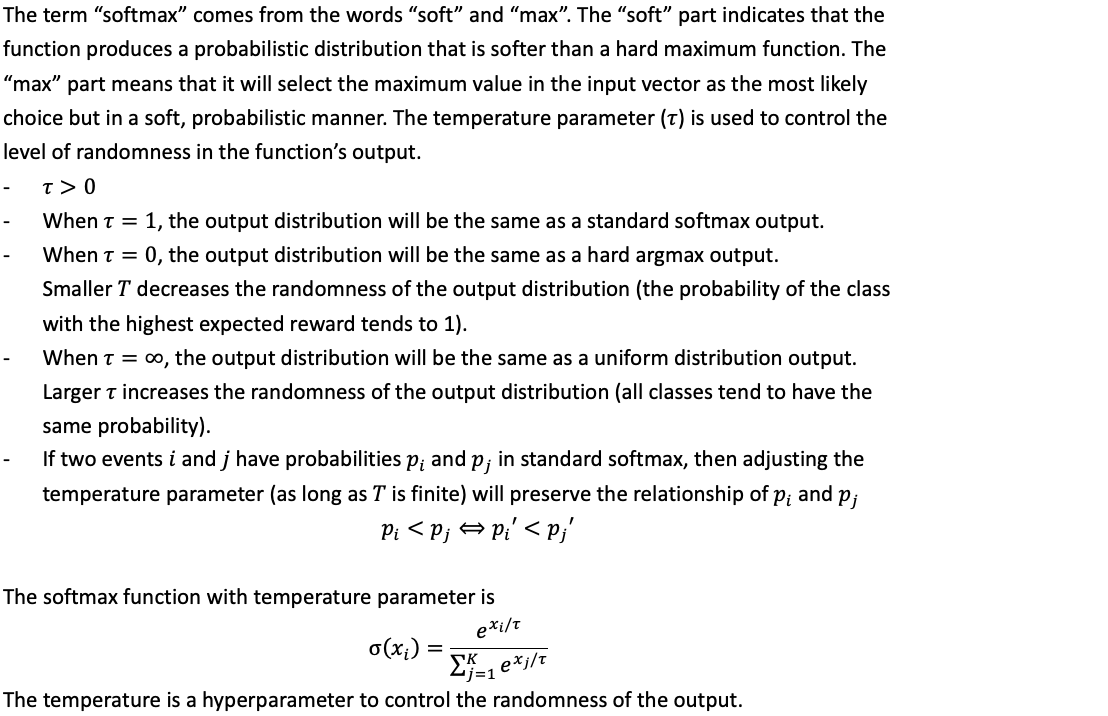

### (3) Probabilities using softmax
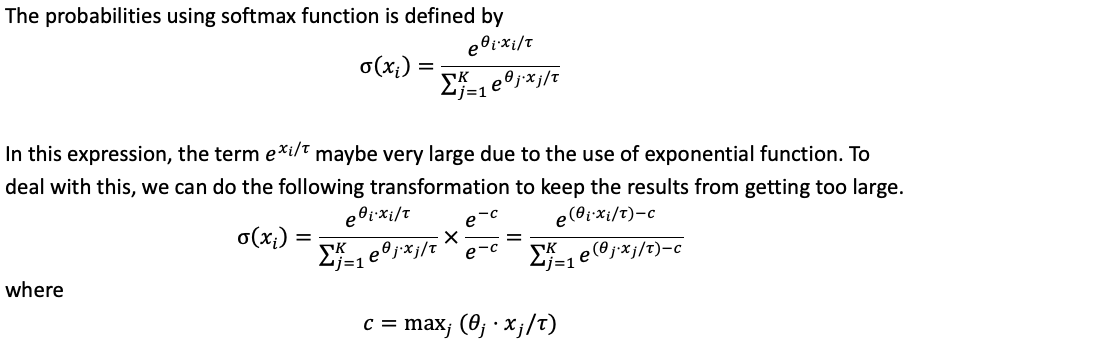

In [21]:
def compute_probabilities(X, theta, temp_parameter):
    """
    Computes the probability that X[i] is labeled as j for j = 0, 1, ..., k-1
    Args:
        X - (n, d) NumPy array (n datapoints each with d features)
        theta - (k, d) NumPy array, where row j represents the parameters of the model for label j
        temp_parameter - the temperature parameter of softmax function (scalar)
    Returns:
        P - (k, n) NumPy array, where each entry P[j][i] is the probability that X[i] is labeled as j
    """
    # Compute the matrix of theta*X' (k,n)
    R = (theta.dot(X.T))/temp_parameter
    # Compute fixed deduction factor for numerical stability (c is a vector: 1xn)
    c = np.max(R, axis=0)
    # Compute P matrix
    P = np.exp(R - c)
    # Divide H by the normalizing term
    P = P/np.sum(P,axis=0)
    return P    

### (4) The cost function and gradient descent
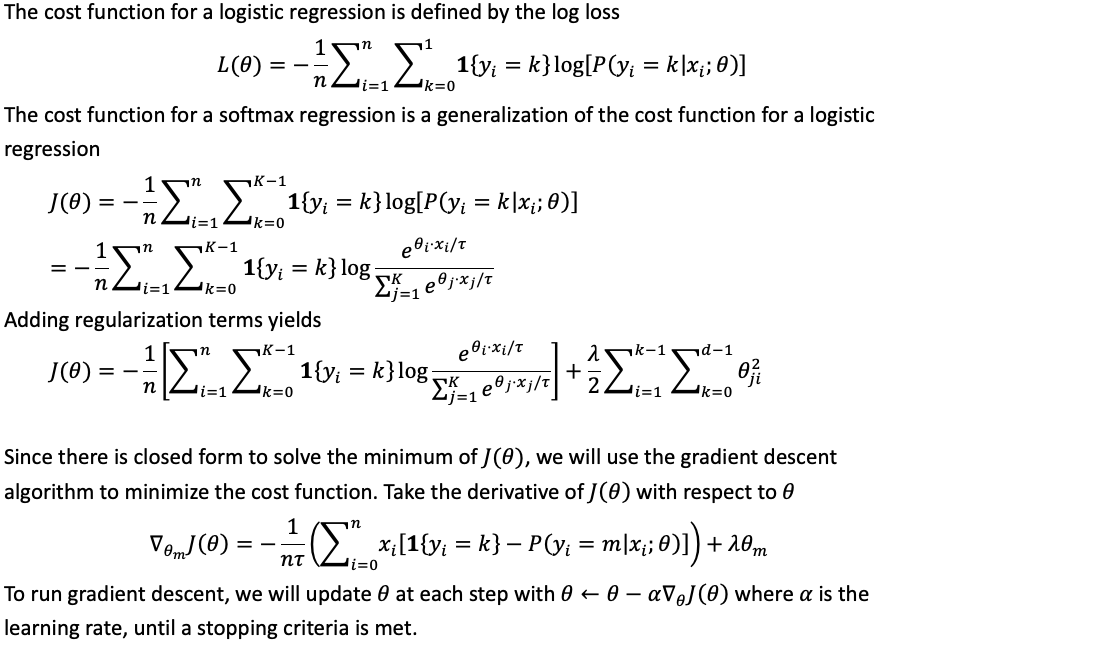

In [22]:
def compute_cost_function(X, Y, theta, lambda_factor, temp_parameter):
    """
    Computes the cost function over every datapoint.
    Args:
        X - (n, d) NumPy array (n datapoints each with d features)
        Y - (n, ) NumPy array containing the labels (a number from 0-9) for each
            data point
        theta - (k, d) NumPy array, where row j represents the parameters of our
                model for label j
        lambda_factor - the regularization constant (scalar)
        temp_parameter - the temperature parameter of softmax function (scalar)
    Returns
        J - the cost value (scalar)
    """
    n          = X.shape[0]
    k          = theta.shape[0]
    p          = compute_probabilities(X, theta, temp_parameter)
    log_p      = np.log(p)
    accurate   = sparse.coo_matrix(([1]*n,(Y,range(n))),shape = (k,n)).toarray()
    error_term = -(1/n)*np.sum(log_p[accurate==1])
    reg_term   = (lambda_factor/2)*np.linalg.norm(theta)**2
    J          = error_term + reg_term
    return J

In [23]:
def run_gradient_descent_iteration(X, Y, theta, alpha, lambda_factor, temp_parameter):
    """
    Runs one step of batch gradient descent

    Args:
        X - (n, d) NumPy array (n datapoints each with d features)
        Y - (n, ) NumPy array containing the labels (a number from 0-9) for each
            data point
        theta - (k, d) NumPy array, where row j represents the parameters of our
                model for label j
        alpha - the learning rate (scalar)
        lambda_factor - the regularization constant (scalar)
        temp_parameter - the temperature parameter of softmax function (scalar)

    Returns:
        theta - (k, d) NumPy array that is the final value of parameters theta
    """
    n = X.shape[0]
    k = theta.shape[0]
    accurate   = sparse.coo_matrix(([1]*n, (Y, range(n))), shape = (k,n)).toarray()
    p          = compute_probabilities(X, theta, temp_parameter)
    delta      = (-1/(temp_parameter*n))*((accurate - p) @ X) + lambda_factor*theta
    return theta-alpha*delta

In [24]:
def softmax_regression(X, Y, temp_parameter, alpha, lambda_factor, k, num_iterations):
    """
    Runs batch gradient descent for a specified number of iterations on a dataset
    with theta initialized to the all-zeros array. Here, theta is a k by d NumPy array
    where row j represents the parameters of our model for label j for
    j = 0, 1, ..., k-1
    Args:
        X - (n, d - 1) NumPy array (n data points, each with d-1 features)
        Y - (n, ) NumPy array containing the labels (a number from 0-9) for each
            data point
        temp_parameter - the temperature parameter of softmax function (scalar)
        alpha - the learning rate (scalar)
        lambda_factor - the regularization constant (scalar)
        k - the number of labels (scalar)
        num_iterations - the number of iterations to run gradient descent (scalar)
    Returns:
        theta - (k, d) NumPy array that is the final value of parameters theta
        cost_function_progression - a Python list containing the cost calculated at each step of gradient descent
    """
    column_of_ones = np.zeros([len(X), 1]) + 1
    X              = np.hstack((column_of_ones, X))
    ### initialize theta 
    theta          = np.zeros([k, X.shape[1]])
    cost_function_progression = []
    for i in range(num_iterations):
        cost_function_progression.append(compute_cost_function(X, Y, theta, lambda_factor, temp_parameter))
        theta = run_gradient_descent_iteration(X, Y, theta, alpha, lambda_factor, temp_parameter)
    return theta, cost_function_progression

In [25]:
def get_classification(X, theta, temp_parameter):
    """
    Args:
        X - (n, d - 1) NumPy array (n data points, each with d - 1 features)
        theta - (k, d) NumPy array where row j represents the parameters of our model for
                label j
        temp_parameter - the temperature parameter of softmax function (scalar)
    Returns:
        Y - (n, ) NumPy array, containing the predicted label (a number between 0-9) for
            each data point
    """
    column_of_ones = np.zeros([len(X), 1]) + 1
    X              = np.hstack((column_of_ones, X))
    probabilities  = compute_probabilities(X, theta, temp_parameter)
    return np.argmax(probabilities, axis = 0)

In [26]:
def softmax_model(train_x,train_y,test_x,temp_parameter=1):
    """
    Trains a softmax classifies useing the following values for parameters:
    alpha = 0.3
    lambda = 1e-4
    num_iterations = 150

    Returns:
        pred_test_y - (m,) NumPy array containing the labels (int) for each test data point
    """
    theta, cost_function_history = softmax_regression(train_x, 
                                                      train_y, 
                                                      temp_parameter, 
                                                      alpha=0.3, 
                                                      lambda_factor=1.0e-4, 
                                                      k=10, 
                                                      num_iterations=150)
    pred_test_y = get_classification(test_x, theta, temp_parameter)
    return pred_test_y,cost_function_history

In [27]:
start_time = time.time()
pred_test_y_softmax_1,cost_function_history_1 = softmax_model(train_x,train_y,test_x,0.5)
pred_test_y_softmax_2,cost_function_history_2 = softmax_model(train_x,train_y,test_x,1)
pred_test_y_softmax_3,cost_function_history_3 = softmax_model(train_x,train_y,test_x,2)
end_time = time.time()
execution_time = end_time - start_time
print(f"execution time：{execution_time} seconds")

execution time：79.68498706817627 seconds


In [28]:
print('softmax, Temperature = 0.5',multi_class_error_rate(test_y,pred_test_y_softmax_1))
print('softmax, Temperature = 1.0',multi_class_error_rate(test_y,pred_test_y_softmax_2))
print('softmax, Temperature = 2.0',multi_class_error_rate(test_y,pred_test_y_softmax_3))

softmax, Temperature = 0.5 0.08399999999999996
softmax, Temperature = 1.0 0.10050000000000003
softmax, Temperature = 2.0 0.1261


In [29]:
def plot_cost_function(cost_function_history,temp):
    plt.plot(range(len(cost_function_history)), cost_function_history)
    plt.ylabel('Cost Function')
    plt.xlabel('Iteration number')
    plt.title('Temperature parameter='+str(temp))
    plt.show()

### Plot the trend of the value of the cost function in the gradient desceding

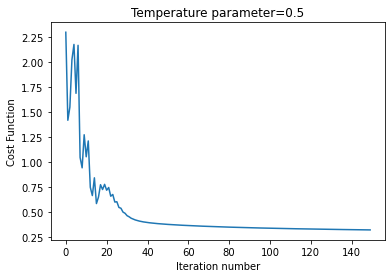

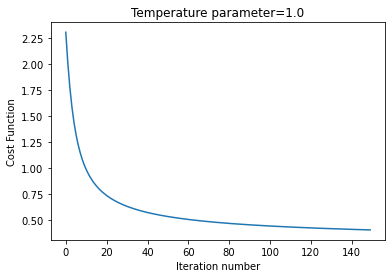

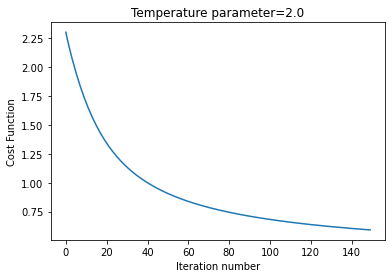

In [30]:
plot_cost_function(cost_function_history_1,0.5)
plot_cost_function(cost_function_history_2,1.0)
plot_cost_function(cost_function_history_3,2.0)

## Draw some samples that no model can correctly identify.

In [31]:
correct_LinearSVC         = (pred_test_y_LinearSVC==test_y).astype(int)
correct_polySVC_PCA10_d3  = (pred_test_y_polySVC_PCA10_d3==test_y).astype(int)
correct_rbfSVC_ori        = (pred_test_y_rbfSVC_ori==test_y).astype(int)
correct_softmax_1         = (pred_test_y_softmax_1==test_y).astype(int)
incorrect_all = (correct_LinearSVC+correct_polySVC_PCA10_d3+correct_rbfSVC_ori+correct_softmax_1)<1

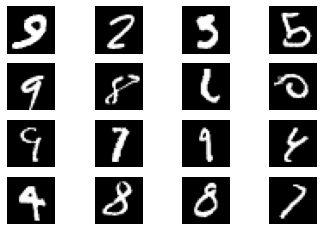

actual [9 2 5 5 9 8 6 0 9 7 9 4 4 8 8 7]
pred_1 [3 8 3 8 4 5 1 4 4 1 1 8 9 3 0 2]
pred_2 [0 8 3 8 4 5 1 2 4 1 1 8 9 3 3 1]
pred_3 [3 8 3 8 4 5 1 2 4 1 1 8 9 3 3 1]
pred_4 [3 8 3 2 4 5 1 6 4 1 1 8 9 3 0 2]


In [32]:
x_incorrect   = test_x[incorrect_all,:]
y_incorrect   = test_y[incorrect_all]
random_n = random.sample(range(1, len(x_incorrect)), 16)

plot_images(x_incorrect[random_n, :])
print('actual',y_incorrect[random_n])
print('pred_1',pred_test_y_LinearSVC[incorrect_all][random_n])
print('pred_2',pred_test_y_polySVC_PCA10_d3[incorrect_all][random_n])
print('pred_3',pred_test_y_rbfSVC_ori[incorrect_all][random_n])
print('pred_4',pred_test_y_softmax_1[incorrect_all][random_n])